<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/project_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

import requests
import zipfile
from pathlib import Path
import pathlib
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader
import os
from pathlib import Path


device = "cuda" if torch.cuda.is_available() else "cpu"


# 1. Get data
from pathlib import Path
import requests
import zipfile


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil

# Define the source and destination paths
source_path = '/content/drive/MyDrive/archive1.zip'
destination_path = '/content/'

# Copy the file
shutil.copy(source_path, destination_path)
print("File copied to /content successfully!")



File copied to /content successfully!


In [4]:
!unzip /content/archive1.zip

Archive:  /content/archive1.zip
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy107.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy108.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy109.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy11.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy110.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy111.jpg  
  inflating:

In [5]:
import requests
import zipfile
from pathlib import Path
import pathlib
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader
import os
from pathlib import Path


Imagepath=("/content/Multi-class Weather Dataset")

#create a function to check the nums of images in each classes
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir("/content/Multi-class Weather Dataset")

#remove shine 127
#remove cloudy46.
#cloudy66
#rain141
#shine131.




There are 4 directories and 0 images in '/content/Multi-class Weather Dataset'.
There are 0 directories and 300 images in '/content/Multi-class Weather Dataset/Cloudy'.
There are 0 directories and 357 images in '/content/Multi-class Weather Dataset/Sunrise'.
There are 0 directories and 253 images in '/content/Multi-class Weather Dataset/Shine'.
There are 0 directories and 215 images in '/content/Multi-class Weather Dataset/Rain'.


In [7]:
#we remove 6 files which has single channels only.
import os
os.remove("/content/Multi-class Weather Dataset/Shine/shine127.jpg")
os.remove("/content/Multi-class Weather Dataset/Cloudy/cloudy46.jpg")
os.remove("/content/Multi-class Weather Dataset/Cloudy/cloudy66.jpg")
os.remove("/content/Multi-class Weather Dataset/Rain/rain141.jpg")
os.remove("/content/Multi-class Weather Dataset/Shine/shine131.jpg")
os.remove("/content/Multi-class Weather Dataset/Cloudy/cloudy71.jpg")

In [8]:
walk_through_dir("/content/Multi-class Weather Dataset")

There are 4 directories and 0 images in '/content/Multi-class Weather Dataset'.
There are 0 directories and 297 images in '/content/Multi-class Weather Dataset/Cloudy'.
There are 0 directories and 357 images in '/content/Multi-class Weather Dataset/Sunrise'.
There are 0 directories and 251 images in '/content/Multi-class Weather Dataset/Shine'.
There are 0 directories and 214 images in '/content/Multi-class Weather Dataset/Rain'.


In [9]:
# Use ImageFolder to create dataset(s)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])


from torchvision import datasets


import os
import pandas as pd
from torchvision.io import read_image



class customdataset(Dataset):
    """
    A custom dataset class for PyTorch that loads images from a directory structure
    where each class of images is stored in a subfolder.

    Attributes:
        transform (callable): A function/transform to apply to the images.
        path (list): A sorted list of all image file paths in the dataset.
        class_name (list): A list of all class names (subfolder names).
        index (dict): A mapping of class names to integer indices.
    """

    def __init__(self, paths, transform):
        """
        Initializes the dataset by loading image paths and class information.

        Args:
            paths (str): Path to the root directory containing subdirectories of images.
            transform (callable): A function/transform to apply to the images.
        """
        # Store the transform to be applied to images.
        self.transfrom = transform

        # Gather all image file paths (.jpg) from the directory and sort them.
        self.path = sorted(list(Path(paths).glob("*/*.jpg")))

        # Get the names of the subdirectories, which represent class names.
        self.class_name = [i.name for i in os.scandir(paths)]

        # Create a mapping of class names to integer indices for labels.
        self.index = {j: i for i, j in enumerate(self.class_name)}

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: The number of images.
        """
        # Return the length of the path list (number of images).
        return len(self.path)

    def __getitem__(self, idx):
        """
        Fetches the image and its corresponding label by index.

        Args:
            idx (int): Index of the desired image.

        Returns:
            tuple: Transformed image and its class label index.
        """
        # Get the image path at the specified index.
        image_idx = self.path[idx]

        # Open the image using PIL.
        PIL_image = Image.open(image_idx)

        # Apply the specified transform to the image.
        transformed = self.transfrom(PIL_image)

        # Extract the class name from the image path's parent directory.
        class_name_id = self.path[idx].parent.name

        # Return the transformed image and its label index.
        return transformed, self.index[class_name_id]

    def classes(self):
        """
        Returns the list of class names.

        Returns:
            list: Class names corresponding to subdirectory names.
        """
        # Return the class names.
        return self.class_name

    def shownimage(self, idx):
        """
        Displays the raw image at the specified index without transformations.

        Args:
            idx (int): Index of the desired image.

        Returns:
            PIL.Image.Image: The image loaded from disk.
        """
        # Get the image path at the specified index.
        image_idx = self.path[idx]

        # Open and return the image using PIL.
        return Image.open(image_idx)



dataset = customdataset(paths="/content/Multi-class Weather Dataset", # target folder of images
                                  transform=data_transform # transforms to perform on data (images)
                                  ) # transforms to perform on labels (if necessary)

train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])
class_names=dataset.classes()

#print out the length of the datas and the classes
len(train_data),len(test_data),class_names


(893, 223, ['Cloudy', 'Sunrise', 'Shine', 'Rain'])

In [10]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b587967d8d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b5879f0c9d0>)

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

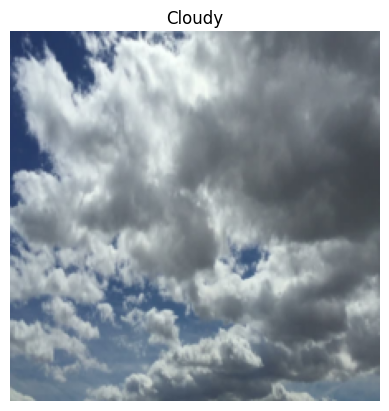

In [12]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Transformer with images

- we need to turn break down the image into a sequence of image patches embeeding and position embedding.

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

Each convolutional kernel will be of size (patch_size x patch_size) or if patch_size=16, (16 x 16) (the equivalent of one whole patch).

And each step or stride of the convolutional kernel will be patch_size pixels long or 16 pixels long (equivalent of stepping to the next patch).





In [13]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)
Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [14]:
from torch import nn


# Pass the image through the convolutional layer

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)


image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

#[batch_size, embedding_dim, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [295, 84, 469, 451, 322]


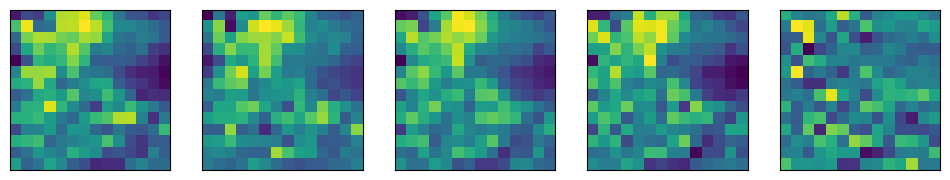

In [15]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [16]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


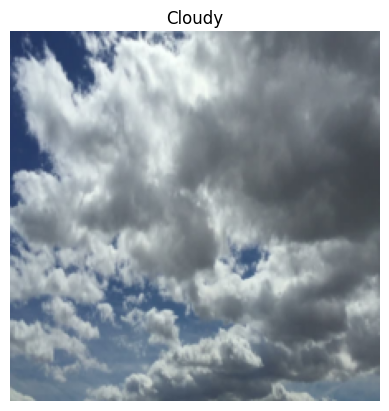

In [17]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

In [18]:
class PatchEmbedding(nn.Module):
  def __init__(self,in_channels=3,out_channel=768,patch_size=16,embedding_dim=768,stride=16,padding=0):
    super().__init__()
    self.conv2d=nn.Conv2d(in_channels=in_channels, out_channels=out_channel, kernel_size=patch_size, stride=stride, padding=padding)
    self.flatten=nn.Flatten(2,3)


  def forward(self,x):
    assert x.shape[-1] % patch_size == 0,"it should be intreger"
    x=self.conv2d(x)
    x=self.flatten(x)

    return torch.permute(x, (0, 2, 1))

 In order to perform classification, we use the standard approach of adding an extra learnable
“classification token” to the sequence:


- When a tensor is wrapped as nn.Parameter and assigned as an attribute of an nn.Module, PyTorch automatically registers it as part of the model's parameters.

Next we need to add the position embedding (spatial information):


In [19]:


# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#patch are related to the (most important)
learn the most related
#relationship to be learnt

In [20]:
class mutihead(nn.Module):
  def __init__(self,embedding_dimention=768,num_heads=12,drop_out=0.0):
    super().__init__()
    #inheritance from nn.module
    self.LayerNorm=nn.LayerNorm(embedding_dimention)
    #we normalize the mean and st for each intsnace(the feature embedding for each patch)
    #in each patch of image

    self.attention=nn.MultiheadAttention(embedding_dimention, num_heads,batch_first=True,dropout=drop_out)
    #we add the self-attention layers

  def forward(self,x):
    x=self.LayerNorm(x)
    attn_output,_=self.attention(query=x,key=x,value=x,need_weights=False)
    #we dont need the weight

    return attn_output







In [21]:
class mutimlp(nn.Module):
  def __init__(self,embedding_dimention=768,hidden_size=3072,drop_out=0.1):
    super().__init__()
    #inheritance from nn.module
    self.LayerNorm=nn.LayerNorm(embedding_dimention)
    #we normalize the mean and st for each intsnace(the feature embedding for each patch)
    #in each patch of image

    self.block=nn.Sequential(nn.Linear(embedding_dimention, hidden_size),nn.GELU(),
    nn.Dropout(p=drop_out),nn.Linear(hidden_size, embedding_dimention),nn.Dropout(p=drop_out))
    #capture more information (project to largerer size)
    #we need to project back into the original size

  def forward(self,x):
    x=self.LayerNorm(x)
    x=self.block(x)

    return x

Encoder: We have encoder to learn the representation by turning a sequence patch into learnt representation

Decoder: from learnt representation into sequence (we dont have it in image)-output not sequence

In [22]:

class Encoder_block(nn.Module):
  def __init__(self,embedding_dimention=768,hidden_size=3072,num_head=12,drop_out=0.1):
    super().__init__()
    self.MAP=mutihead(embedding_dimention,num_head,drop_out=0.0)
    self.MLP=mutimlp(embedding_dimention,hidden_size,drop_out=0.1)

  def forward(self,x):
    output_1=self.MAP(x)+x
    output_2=self.MLP(output_1)+output_1

    return output_2



In [23]:
!pip install -q torchinfo

In [24]:
from torchinfo import summary

classification

In [25]:

class Vision_transformer(nn.Module):
  def __init__(self,in_channel=3,image_size=224,patch_size=16,embedding_dimention=768,hidden_size=3072,num_head=12,drop_out=0.1,class_num=len(class_names),num_encode=12):
    super().__init__()



    assert image_size % patch_size ==0,"not divisible by zero"
    self.N=(image_size)*image_size//(patch_size**2)

    #patch_embedding
    self.patch_embedding=PatchEmbedding(in_channels=in_channel,patch_size=patch_size,embedding_dim=embedding_dimention)

    #create class_embedding
    self.class_embedding_token=nn.Parameter(data=torch.randn(1,1, embedding_dimention))
    #create position_embedding
    self.position_embedding_token=nn.Parameter(data=torch.randn(1,self.N+1, embedding_dimention))
    #create 12 embedding blocks
    self.encoder_12=nn.Sequential(*[Encoder_block(embedding_dimention,hidden_size,num_head,drop_out) for _ in range(num_encode)])

    #final_head
    self.head=nn.Sequential(nn.LayerNorm(embedding_dimention),nn.Linear(embedding_dimention,class_num))

    #dropout
    self.dropout=nn.Dropout(drop_out)

  def forward(self,x):
    batch_size=x.shape[0]

    x=self.patch_embedding(x)

    class_embedding_token=self.class_embedding_token.expand(batch_size,-1,-1)

    x=torch.cat((class_embedding_token,x),dim=1)

    x=self.position_embedding_token+x

    x=self.dropout(x)

    x=self.encoder_12(x)
    x=self.head(x[:,0,:])


    return x

In [26]:
vit=Vision_transformer()
vit

Vision_transformer(
  (patch_embedding): PatchEmbedding(
    (conv2d): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (encoder_12): Sequential(
    (0): Encoder_block(
      (MAP): mutihead(
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (MLP): mutimlp(
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (block): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Encoder_block(
      (MAP): mutihead(
        (LayerNorm): LayerNorm((768,), eps=1e-05, 

In [27]:
summary(model=Vision_transformer(),input_size=(1,3,224,224),col_names=["input_size","output_size","num_params","trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape     Output Shape    Param #         Trainable
Vision_transformer (Vision_transformer)                 [1, 3, 224, 224] [1, 4]          152,064         True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224] [1, 196, 768]   --              True
│    └─Conv2d (conv2d)                                  [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
│    └─Flatten (flatten)                                [1, 768, 14, 14] [1, 768, 196]   --              --
├─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
├─Sequential (encoder_12)                               [1, 197, 768]   [1, 197, 768]   --              True
│    └─Encoder_block (0)                                [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─mutihead (MAP)                              [1, 197, 768]   [1, 197, 768]   2,363,904       True
│    │    └─m

training code:

reduce the weight(weight decay;make it smaller)

In [28]:
loss_fn=torch.nn.CrossEntropyLoss()
loss_fn

optimizer=torch.optim.Adam(params=vit.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-03, weight_decay=0.1)

In [29]:



def one_epoch_training(model,optimizer,train_dataloader=train_dataloader,test_dataloader=test_dataloader,device=device):
  model.to(device)
  model.train()
  running_lost=0
  train_acc=0

  total_test_lost=0
  total_test_acc=0

  for batch,(data_x,labels) in enumerate(train_dataloader):
    #set the gradident caluclation is zero for every batch
    optimizer.zero_grad()
    #input should be (batch,1,2,3..k dimention)
    logit_outputs=model(data_x.to(device))


    #compute the lost for each batch
    loss=loss_fn(logit_outputs, labels.to(device))
    loss.backward()
    #compute average
    acc=sum(logit_outputs.argmax(-1)==labels.to(device)).item()
    train_acc=train_acc+acc

    #save the loss into the running_lost:
    running_lost=running_lost+loss
    #we change the weight for each batches
    optimizer.step()


  model.eval()
  #turn off the drpop out or lynorm

  with torch.no_grad():
    for i, (data_x,labels) in enumerate(test_dataloader):
      logit_outputs=model(data_x.to(device))
      #compute the lost for each batch
      test_loss=loss_fn(logit_outputs, labels.to(device))
      #store the total lost
      total_test_lost=total_test_lost+test_loss

      #compute the acc for each batch
      acc=sum(logit_outputs.argmax(-1)==labels.to(device)).item()
      total_test_acc=total_test_acc+acc

  #we have total loss for one epoches (in all batch)
  print (f"Training_loss {running_lost/len((train_dataloader))}| Testing_loss{total_test_lost/len((test_dataloader))} |Training_acc {train_acc/len(train_data)}| testing_acc{total_test_acc/len(test_data)}")
  return running_lost/len((train_dataloader)),total_test_lost/len((test_dataloader)),train_acc/len(train_data),total_test_acc/len(test_data)





In [30]:
Epoch=8
for i in range(Epoch):
  Result={"train_loss":[],"test_loss":[],"train_acc":[],"test_acc":[],}
  print (f"we are in epoch {i+1}")
  train_loss,test_loss,train_acc,test_acc=one_epoch_training(model=vit,optimizer=optimizer)
  Result["train_loss"].append(train_loss)
  Result["test_loss"].append(test_loss)
  Result["train_acc"].append(train_acc)
  Result["test_acc"].append(test_acc)



we are in epoch 1
Training_loss 1.9512840509414673| Testing_loss0.9378478527069092 |Training_acc 0.3639417693169093| testing_acc0.5605381165919282
we are in epoch 2
Training_loss 0.8721330165863037| Testing_loss0.7933446764945984 |Training_acc 0.6237402015677491| testing_acc0.6412556053811659
we are in epoch 3
Training_loss 0.8344606161117554| Testing_loss0.7755890488624573 |Training_acc 0.6338185890257558| testing_acc0.7219730941704036
we are in epoch 4
Training_loss 0.8421685695648193| Testing_loss0.8638526797294617 |Training_acc 0.5991041433370661| testing_acc0.6860986547085202
we are in epoch 5
Training_loss 0.9317032694816589| Testing_loss0.8349016308784485 |Training_acc 0.5699888017917133| testing_acc0.6771300448430493
we are in epoch 6
Training_loss 0.9373701810836792| Testing_loss0.9649750590324402 |Training_acc 0.5722284434490481| testing_acc0.600896860986547
we are in epoch 7
Training_loss 0.8185535073280334| Testing_loss0.7665179371833801 |Training_acc 0.6528555431131019| te

Pre-Trained model:

We can do a pre-trained model because out performance is not really good

source: https://pytorch.org/vision/stable/models.html
https://pytorch.org/vision/stable/models.html

In [31]:
pre_vit=torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT).to(device)



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 100MB/s] 


In [32]:
for parameter in pre_vit.parameters():
    parameter.requires_grad = False

pre_vit.heads=nn.Linear(768,4)



In [33]:
summary(model=pre_vit,input_size=(1,3,224,224),col_names=["input_size","output_size","num_params","trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 4]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [38]:
transforms=torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Load our dataset:

In [39]:
Dataset=datasets.ImageFolder(root="/content/Multi-class Weather Dataset",transform=transforms)


train_data, test_data = torch.utils.data.random_split(Dataset, [0.8,0.2])


# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader2 = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader2 = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader2, test_dataloader2


(<torch.utils.data.dataloader.DataLoader at 0x7b58542522f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b58542520e0>)

In [40]:
loss_fn=torch.nn.CrossEntropyLoss()
loss_fn

optimizer2=torch.optim.Adam(params=pre_vit.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-03, weight_decay=0.1)

In [42]:
Epoch=10
for i in range(Epoch):
  Result2={"train_loss":[],"test_loss":[],"train_acc":[],"test_acc":[],}
  print (f"we are in epoch {i+1}")
  train_loss,test_loss,train_acc,test_acc=one_epoch_training(model=pre_vit,optimizer=optimizer2,train_dataloader=train_dataloader2,test_dataloader=test_dataloader2)
  Result2["train_loss"].append(train_loss)
  Result2["test_loss"].append(test_loss)
  Result2["train_acc"].append(train_acc)
  Result2["test_acc"].append(test_acc)


we are in epoch 1
Training_loss 0.3408390283584595| Testing_loss0.2273985892534256 |Training_acc 0.8928571428571429| testing_acc0.9596412556053812
we are in epoch 2
Training_loss 0.18791861832141876| Testing_loss0.18029850721359253 |Training_acc 0.9631696428571429| testing_acc0.9596412556053812
we are in epoch 3
Training_loss 0.15784546732902527| Testing_loss0.16040584444999695 |Training_acc 0.9654017857142857| testing_acc0.9596412556053812
we are in epoch 4
Training_loss 0.14157183468341827| Testing_loss0.15027549862861633 |Training_acc 0.9765625| testing_acc0.9596412556053812
we are in epoch 5
Training_loss 0.13261035084724426| Testing_loss0.1464332640171051 |Training_acc 0.9754464285714286| testing_acc0.9596412556053812
we are in epoch 6
Training_loss 0.12428749352693558| Testing_loss0.1460171490907669 |Training_acc 0.9765625| testing_acc0.9596412556053812
we are in epoch 7
Training_loss 0.12041356414556503| Testing_loss0.14255522191524506 |Training_acc 0.9765625| testing_acc0.95964